# Grad Cam
> In this notebook we will be using Grad Cam (*Gradient-weighted Class Activation Mapping*) to make heatmap visuals of the last layer in the model. The goal of this notebook is to overlay the heatmaps on on the MRI scans to hopefully indicate where the tumors may be located at. I followed the guidance of [Keras Documentation](https://keras.io/examples/vision/grad_cam/) to make this work.

>The idea behind Grad-CAM is to compute the gradient of the output class score with respect to the feature maps of the final convolutional layer of a neural network. These gradients are then used to weight the feature maps, producing a coarse localization map that indicates the regions of the input image that were most important for the network's prediction.

The main steps of the Grad-CAM algorithm is:


1.   Feed the input image into the neural network and obtain the output class score.
2.   Compute the gradient of the output score with respect to the feature maps of the final convolutional layer.
3. Compute the global average pooling of the gradients over each feature map, resulting in a set of weights.
4. Multiply each feature map by its corresponding weight and sum them up to obtain the final localization map.
5. Resize the localization map to the size of the input image and apply a ReLU activation function to remove negative values.
6. Overlay the resulting heatmap on top of the input image to visualize the important regions for the predicted class.



---

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.display import Image, display
from PIL import Image

import tensorflow as tf
from tensorflow import keras


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Instantiating variables
> If you run this on your own machine, please adjust these variables to your own personal needs and locations. 

In [2]:
image_directory = '/content/drive/MyDrive/Capstone/images/brain_scans'
visuals_directory = '/content/drive/MyDrive/Capstone/images/visuals/'
modeling_directory = '/content/drive/MyDrive/Capstone/data/'
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

modela = keras.models.load_model(modeling_directory + 'modelA') #conv2d_4
modelb = keras.models.load_model(modeling_directory + 'modelB') #conv2d_12
modelc = keras.models.load_model(modeling_directory + 'modelC') #conv2d_20

#last convultion layer
last_conv_layer_name = "conv2d_20"

#setting standard img size
img_size = (512, 512)

# The local path to our target image
img_path = '/content/drive/MyDrive/Capstone/images/brain_scans/meningioma/Te-meTr_0000.jpg'

#Setting which model will be utilized
model = modelc

---

## Grad-CAM

In [5]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 5
    img = Image.open(img_path).convert('L')
    img = img.resize(img_size)
    # `array` is a float32 Numpy array of shape (512, 512, 1)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (512, 512, 1)
    array = np.expand_dims(array, axis=0)
    return array


In [6]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [7]:
# Prepare image
img_array = tf.keras.applications.xception.preprocess_input(get_img_array(img_path, size=img_size))

In [8]:
# Remove last layer's softmax
modela.layers[-1].activation = None

In [9]:
# Print what the top predicted class is
preds = modela.predict(img_array)
print("Predicted:", np.argmax(preds, axis =1))

1/1 [==============================] - 7s 7s/step
Predicted: [2]


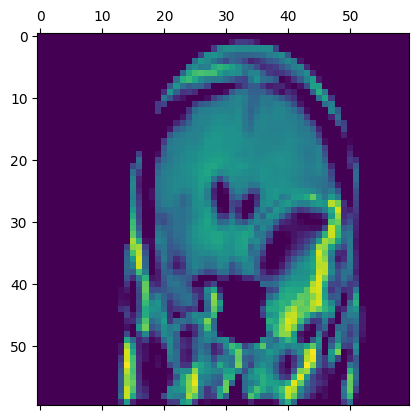

In [17]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display and save heatmap
plt.matshow(heatmap)
plt.savefig(visuals_directory)
plt.show()

<ipython-input-14-ee000b88384b>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


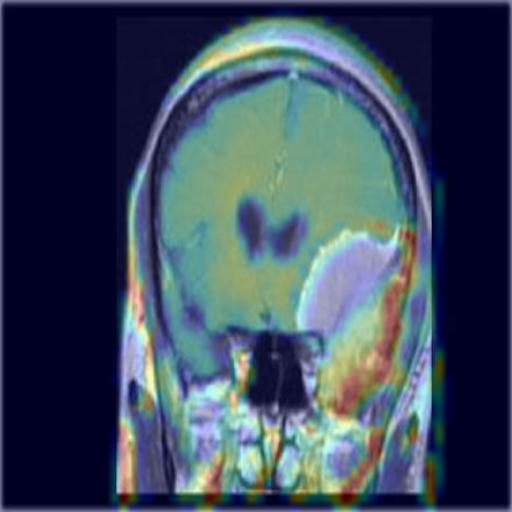

In [14]:
def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.4):
    # Load the original image
    # `img` is a PIL image of size 299x299
    img = Image.open(img_path).convert('L')
    img = img.resize((512,512))
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    img = keras.preprocessing.image.img_to_array(img)
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(512))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    Image.open(cam_path).show()


save_and_display_gradcam(img_path, heatmap, f"{visuals_directory}/grad_cam.jpg")

<ipython-input-14-ee000b88384b>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


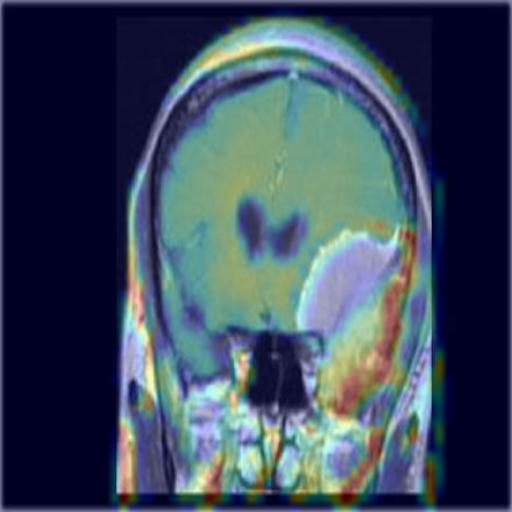

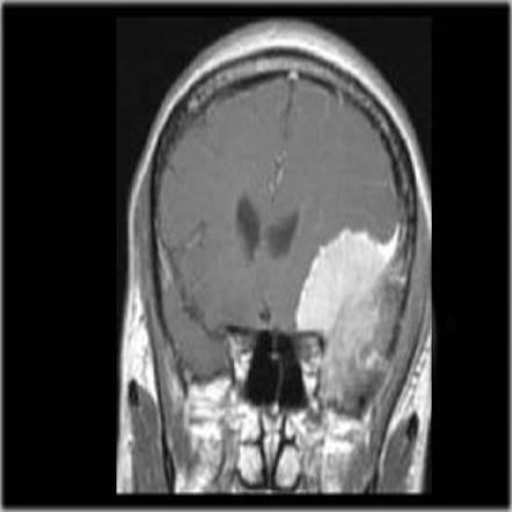

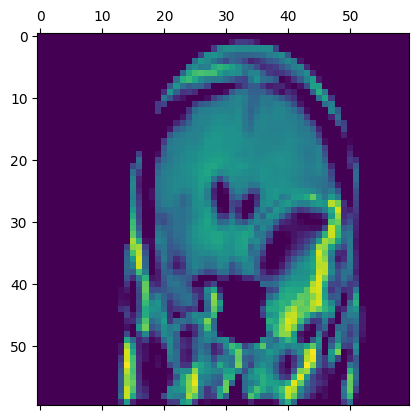

In [15]:
save_and_display_gradcam(img_path, heatmap, f"{visuals_directory}/grad_cam.jpg")
plt.matshow(heatmap)
img = Image.open(img_path).convert('L')
img = img.resize((512,512))
img.show()
plt.show();